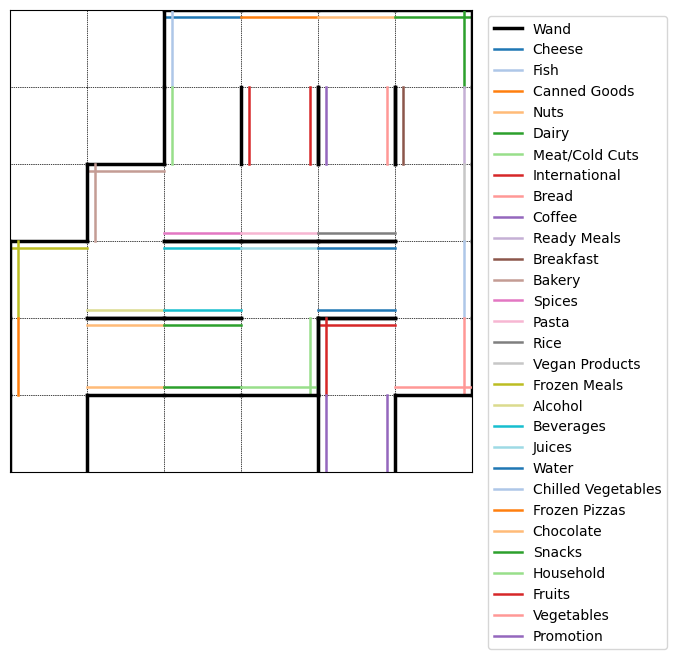

In [1]:
from supermarket import Grid
grid = Grid("grid_eng.txt")
grid.plot(saving_path="empty_grid.jpg")

## Computing Cost-/Path-Matrix for the different product-types

In [2]:
import numpy as np
from supermarket import Zelle
import astar
def compute_product_types_dict(grid:Grid, start_cell, end_cell):
    """
    Creates a dictionary mapping each product type in the grid to its cell coordinates.

    Keys:
        - "start": The starting cell (start_cell parameter)
        - "end": The ending cell (end_cell parameter)
        - All product types (as strings) found in the grid cells

    Values:
        - For "start" and "end": the coordinates (row, column) of the respective cell
        - For product types: a tuple (row, column) indicating the cell where the product type is located

    Procedure:
        1. Iterates over all cells in the 2D grid.
        2. Checks each side of the cell (N, E, S, W).
        3. If a side contains a product type (string), it is added as a key to the dictionary,
           with the value being the coordinates of the cell.
        4. Start and end cells are added as separate keys.

    Returns:
        - Dictionary containing start, end, and all found product types with their locations.
    """
    dict = {}
    dict["start"] = start_cell
    for (r, c), cell in np.ndenumerate(grid.grid):
        assert type(cell) == Zelle
        seiten = cell.seiten
        products_in_cell = []
        if type(seiten["N"]) == str:
            products_in_cell.append(seiten["N"])
        if type(seiten["E"]) == str:
            products_in_cell.append(seiten["E"])
        if type(seiten["S"]) == str:
            products_in_cell.append(seiten["S"])
        if type(seiten["W"]) == str:
            products_in_cell.append(seiten["W"])
        
        for product in products_in_cell:
            dict[product] = (r,c)
    dict["end"] = end_cell
    return dict

def compute_optimal_trajectories(grid:Grid, start_cell, end_cell):
    """
    Computes the optimal trajectories and their costs between all product types, 
    including the start and end cells, in a grid using the A* algorithm.

    Procedure:
        1. Generates a dictionary of product types and their cell coordinates 
           using `compute_product_types_dict`.
        2. Assigns a unique index to each product type for matrix representation.
        3. Initializes two square matrices:
            - `product_type_cost_matrix`: stores the path length (cost) between each pair of product types
            - `product_type_path_matrix`: stores the actual path (list of cell coordinates) between each pair
        4. Iterates over all pairs of product types (including start and end) and computes the shortest path 
           using the `astar` function.
        5. Stores the path cost and the path itself in the corresponding matrices.

    Returns:
        - product_type_cost_matrix: 2D NumPy array with path lengths between all product types
        - product_type_path_matrix: 2D NumPy array with paths (lists of coordinates) between all product types
        - product_type_indizes: dictionary mapping product type names to their matrix indices
    """
    product_types_dict = compute_product_types_dict(grid, start_cell, end_cell)
    number_of_product_types = len(product_types_dict)
    product_type_cost_matrix = np.empty((number_of_product_types, number_of_product_types), dtype=object)
    product_type_path_matrix = np.empty((number_of_product_types, number_of_product_types), dtype=object)
    product_type_indizes = {}
    i = 0
    for product in product_types_dict:
        product_type_indizes[product] = i
        i += 1
    for product_start in product_types_dict:
        for product_end in product_types_dict:
            path = astar.astar(grid, product_types_dict[product_start], product_types_dict[product_end])
            if path is not None:
                cost = len(path)-1
                product_type_cost_matrix[product_type_indizes[product_start], product_type_indizes[product_end]] = cost
                product_type_path_matrix[product_type_indizes[product_start], product_type_indizes[product_end]] = path
                #print(product_start, product_end, cost)
    return product_type_cost_matrix, product_type_path_matrix, product_type_indizes

J_product_category, P_product_category, product_type_indizes = compute_optimal_trajectories(grid, (5,4), (5,0))

## Computing Cost-/Path-Matrix for the different products based on the matrizes of the product_types

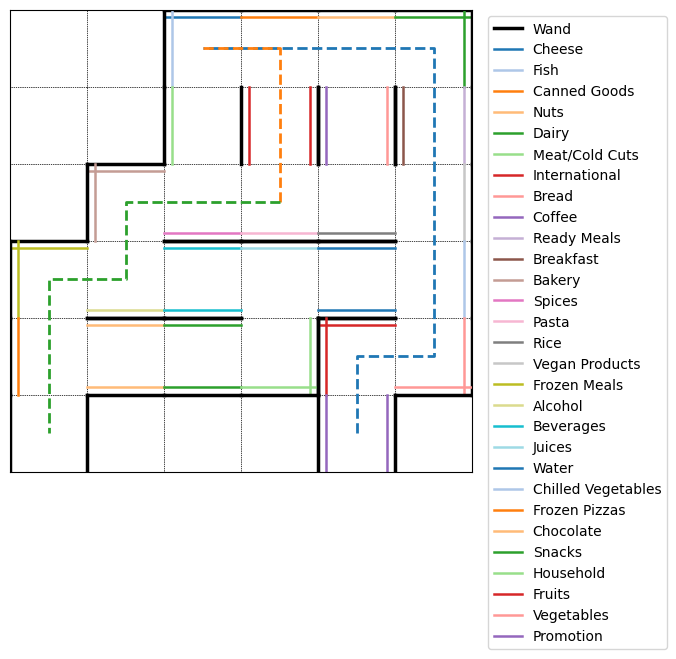

In [3]:
def create_product_cost_path_matrix(shopping_list, product_type_cost_matrix, product_type_path_matrix, product_type_indizes):
    """
    Creates cost and path matrices specifically for the products in a shopping list, 
    including the start and end points, by mapping from the full product type matrices.

    Procedure:
        1. Adds "start" and "end" to the shopping list.
        2. Initializes empty matrices for:
            - product_cost_matrix: stores the path length (cost) between each pair of shopping list items
            - product_path_matrix: stores the actual path (list of coordinates) between each pair
        3. Creates a mapping from shopping list item names to their indices in the matrices.
        4. Fills the matrices by looking up the costs and paths in the full product type matrices 
           using the corresponding product type indices.

    Parameters:
        - shopping_list: dictionary mapping item names to their product types
        - product_type_cost_matrix: full cost matrix for all product types (from compute_optimal_trajectories)
        - product_type_path_matrix: full path matrix for all product types
        - product_type_indizes: dictionary mapping product types to their indices in the full matrices

    Returns:
        - product_cost_matrix: 2D NumPy array with path lengths between shopping list items
        - product_path_matrix: 2D NumPy array with paths (lists of coordinates) between shopping list items
        - product_indizes: dictionary mapping shopping list item names to their indices in the returned matrices
    """
    # Add start and end to shopping-list
    if "start" not in shopping_list:
        shopping_list = {"start": "start", **shopping_list}
    if "end" not in shopping_list:
        shopping_list["end"] = "end"

    number_of_products = len(shopping_list)
    product_cost_matrix = np.empty((number_of_products, number_of_products), dtype=object)
    product_path_matrix = np.empty((number_of_products, number_of_products), dtype=object)

    # Create a mapping from shopping list item names to their indices in the matrices.
    product_indizes = {}
    i = 0
    for product in shopping_list:
        product_indizes[product] = i
        i += 1
    
    for product_start, product_type_start in shopping_list.items():
        for product_end, product_type_end in shopping_list.items():
            i_product_start = product_indizes[product_start]
            i_product_end = product_indizes[product_end]
            i_product_type_start = product_type_indizes[product_type_start]
            i_product_type_end = product_type_indizes[product_type_end]
            product_cost_matrix[i_product_start, i_product_end] = product_type_cost_matrix[i_product_type_start, i_product_type_end]
            product_path_matrix[i_product_start, i_product_end] = product_type_path_matrix[i_product_type_start, i_product_type_end]
    return product_cost_matrix, product_path_matrix, product_indizes    

# shopping_list = {
#     "Cheddar": "Käse",
#     "Cashews": "Nüsse",
#     "Penne": "Nudeln",
#     "Pizza": "Tiefkühlgerichte",
#     "Bandnudeln": "Nudeln",
#     "Blumen": "Aktion"
# }
shopping_list = {
    "Cheddar": "Cheese",
    "Cashews": "Nuts",
    "Penne": "Pasta",
    "Pizza": "Frozen Meals",
    "Bandnudeln": "Pasta",
    "Blumen": "Promotion"
}

J_product, P_product, product_indizes = create_product_cost_path_matrix(shopping_list, J_product_category, P_product_category, product_type_indizes)

#path = ("Penne", "Blumen")
#print(f"Path from {path[0]} to {path[1]}")
#plot_grid(grid, [product_path_matrix[product_indizes[path[0]], product_indizes[path[1]]]])
grid.plot([P_product[0, 1], P_product[1, 3], P_product[3, 7]], saving_path="grid_with_path.jpg")


In [4]:
import matplotlib.pyplot as plt
# small_shopping_list = {
#     "Cheddar": "Käse",
#     "Cashews": "Nüsse",
#     "Penne": "Nudeln",
#     "Pizza": "Tiefkühlgerichte"
# }
# J_product_small, P_product_small, product_indizes_small = create_product_cost_path_matrix(small_shopping_list, J_product_category, P_product_category, product_type_indizes)

# def create_matrix_latex_str(shopping_list, J_product):
#     # Produktliste
#     products = ["start"] + list(small_shopping_list.keys()) + ["end"]

#     # LaTeX-Matrix mit Labels erzeugen
#     latex_str = "\\[\n\\begin{array}{c|" + "c"*len(products) + "}\n"

#     # Erste Zeile: Spaltennamen
#     latex_str += " & " + " & ".join(products) + " \\\\\n"
#     latex_str += "\\hline\n"

#     # Restliche Zeilen: Zeilenname + Werte
#     for label, row in zip(products, J_product):
#         latex_str += label + " & " + " & ".join(map(str, row)) + " \\\\\n"

#     latex_str += "\\end{array}\n\\]"

#     print(latex_str)

# create_matrix_latex_str(shopping_list, J_product_small)


## Easy heuristic for optimal route by length  
Unfortunaltely this computation scales by n!, where n is the number of items on the shopping list. Therefore this might not be the preferred algorithm for big shopping_lists.

[0, 6, 2, 1, 3, 5, 4, 7] 18


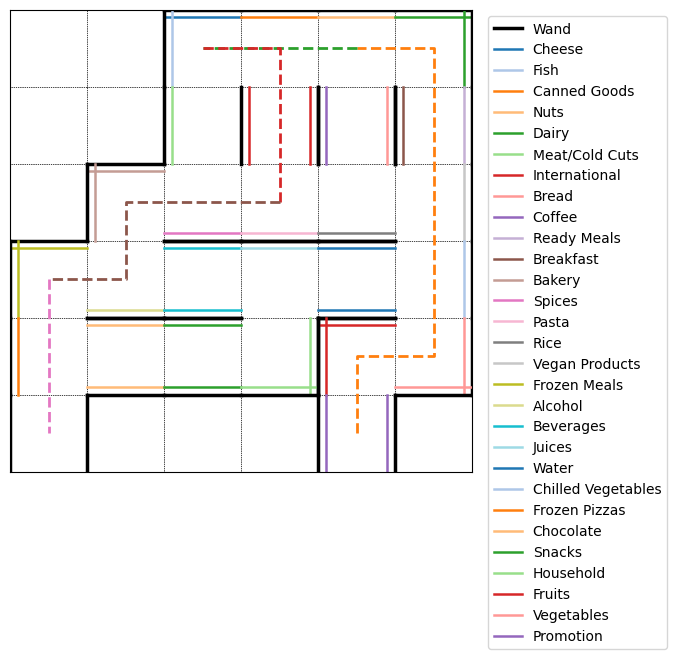

In [5]:
from itertools import permutations

def compute_timecost_from_order(order, product_cost_matrix):
    total_cost = 0
    for i in range(len(order)-1):
        total_cost += product_cost_matrix[order[i], order[i+1]]
    return total_cost

def get_path_from_order(order, product_path_matrix):
    path = []
    for i in range(len(order)-1):
        path.append(product_path_matrix[order[i], order[i+1]])
    return path

def get_complete_order(middle_indices_order, start_index, end_index):
    return [start_index]+middle_indices_order+[end_index]

def find_shortest_way_easy_heuristic(product_cost_matrix):
    n = product_cost_matrix.shape[0]
    start_index = 0
    end_index = n-1

    middle_indices = list(range(1, n-1))
    best_cost = np.inf
    best_order = None

    for order in permutations(middle_indices):
        full_order = get_complete_order(list(order), start_index, end_index)
        cost = compute_timecost_from_order(full_order, product_cost_matrix)
        if cost < best_cost:
            best_cost = cost
            best_order = full_order

    return best_order, best_cost



shortest_order, shortest_order_cost = find_shortest_way_easy_heuristic(J_product)
shortest_path = get_path_from_order(shortest_order, P_product)
print(shortest_order, shortest_order_cost)
grid.plot(shortest_path, saving_path="Time brute-force-heuristic.jpg")

# Single solution based mataheuristic

In [6]:
import math
shopping_list = {
    "Cheddar": "Cheese",
    "Mozzarella": "Cheese",
    "Salmon": "Fish",
    "Tuna": "Canned Goods",
    "Cashews": "Nuts",
    "Almonds": "Nuts",
    "Penne": "Pasta",
    "Spaghetti": "Pasta",
    "Rice": "Rice",
    "Pizza": "Frozen Meals",
    "Frozen Vegetables": "Chilled Vegetables",
    "Chocolate": "Chocolate",
    "Coffee Beans": "Coffee",
    "Croissant": "Bakery",
    "Baguette": "Bakery",
    "Orange Juice": "Juices",
    "Mineral Water": "Water",
    "Apple": "Fruits",
    "Banana": "Fruits",
    "Carrot": "Vegetables",
    "Broccoli": "Vegetables",
    "Chicken Breast": "Meat/Cold Cuts",
    "Sausage": "Meat/Cold Cuts",
    "Soy Milk": "Vegan Products",
    "Flowers": "Promotion"
}
J_product, P_product, product_indizes = create_product_cost_path_matrix(shopping_list, J_product_category, P_product_category, product_type_indizes)
print(f"Theoretical number of orders possible: {math.factorial(len(shopping_list))}")



Theoretical number of orders possible: 15511210043330985984000000


## Local search

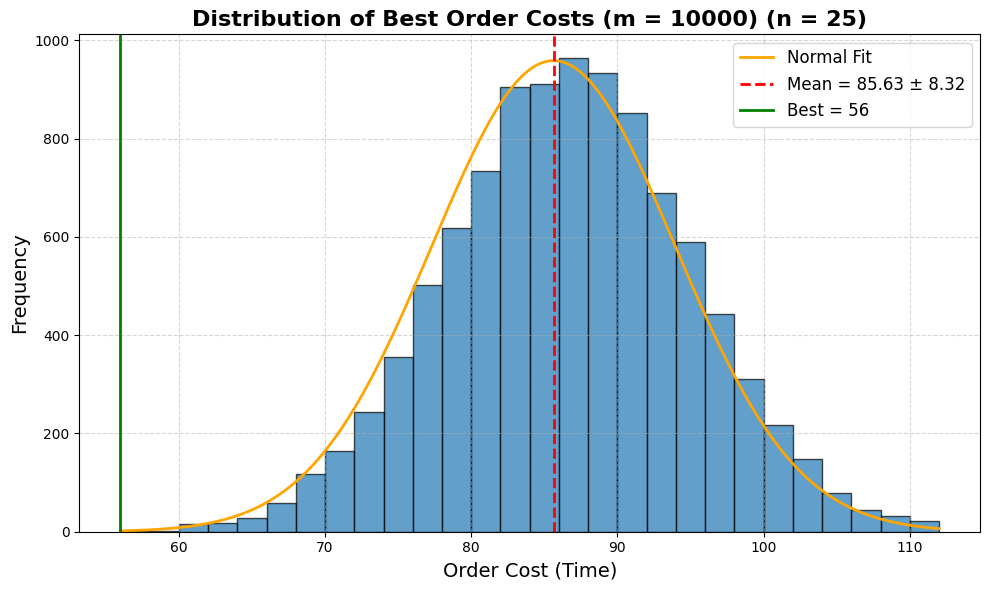

In [7]:
import random
from helping_functions import plot_costs


def generate_random_order(number_of_products):
    order = list(range(1, number_of_products+1))
    random.shuffle(order)
    return order
    
def compute_neighbours1(order):
    neighbour_orders = []
    for i in range(len(order)-1):
        # For each neighbour switch two products which are next to each other
        # n being number of products on shopping list
        # n-1 neighbours -> O(n)
        new_order = order.copy()
        new_order[i], new_order[i+1] = new_order[i+1], new_order[i]
        neighbour_orders.append([0]+new_order+[len(new_order)+1])
    return neighbour_orders

def local_search(J_product, printing = False, compute_neighbours_func = compute_neighbours1, start_order = None):
    if printing:
        print("Starting local search:")
    number_of_products = J_product.shape[0]-2

    # If no start-order is given, create a random start-order
    if start_order is None:
        best_order = generate_random_order(number_of_products)
        best_order = get_complete_order(best_order, 0, number_of_products + 1)
    else:
        best_order = start_order
        if best_order[0] != 0:
            best_order = get_complete_order(best_order, 0, number_of_products + 1)
    
    no_better_order = True
    epoch = 1
    while no_better_order:
        # print(f"Epoch: {epoch}")
        # print(best_order)
        epoch += 1
        best_order_cost = compute_timecost_from_order(best_order, J_product)
        neighbours = compute_neighbours_func(best_order[1:number_of_products+1])
        #print(neighbours)
        neighbours_cost = [compute_timecost_from_order(neighbour, J_product) for neighbour in neighbours]
        best_neighbour_cost = min(neighbours_cost)
        if best_neighbour_cost < best_order_cost:
            best_neighbour_index = neighbours_cost.index(best_neighbour_cost)
            best_order = neighbours[best_neighbour_index]
            best_order_cost = best_neighbour_cost
        else:
            no_better_order = False
            if printing:
                print(f"No better neighbour found after {epoch} epochs")
                print(f"Best Order: {best_order}")
                print(f"Best Cost: {best_order_cost}")
                print()
    return best_order, best_order_cost

def perform_local_search_m_times(m, J_product, compute_neighbours_func, shopping_list):
    best_orders, best_order_costs = [], []
    for i in range(m):
        best_order, best_order_cost = local_search(J_product, compute_neighbours_func=compute_neighbours_func)
        best_orders.append(best_order)
        best_order_costs.append(best_order_cost)

    plot_costs(best_order_costs, shopping_list=shopping_list)


perform_local_search_m_times(10000, J_product, compute_neighbours1, shopping_list)

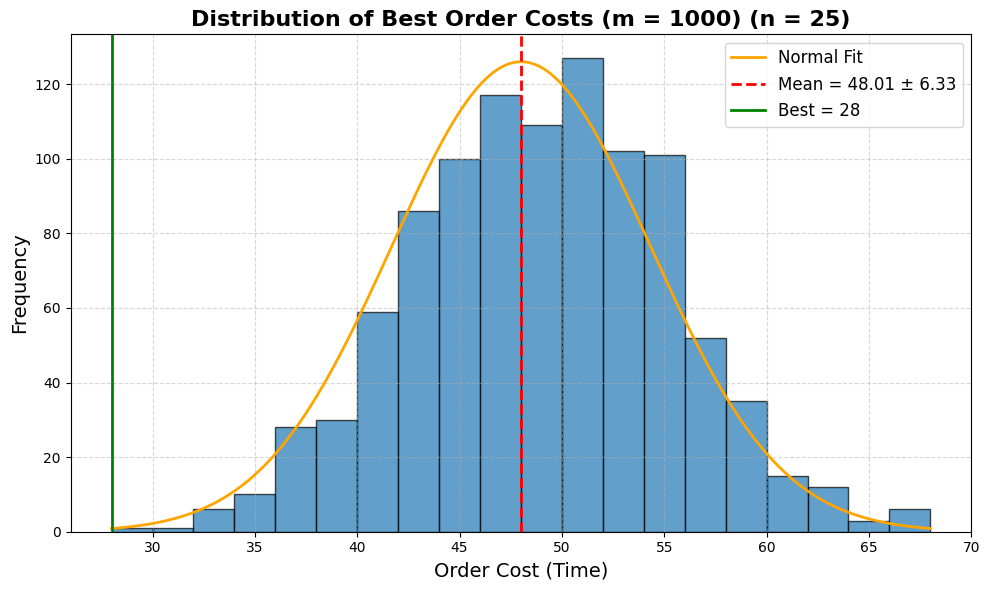

In [8]:
def compute_neighbours2(order):
    neighbour_orders = []
    for i in range(len(order)-1):
        for j in range(i,len(order)-1):
            # For each neighbour switch two products (must not be next to each other)
            # n being number of products on shopping list
            # -> (n-1)+(n-2)+...+1 = (n-1)*n/2 neighbours -> O(n^2)
            new_order = order.copy()
            new_order[i], new_order[j] = new_order[j], new_order[i]
            neighbour_orders.append([0]+new_order+[len(new_order)+1])
    return neighbour_orders

perform_local_search_m_times(1000, J_product, compute_neighbours2, shopping_list)

# GRASP

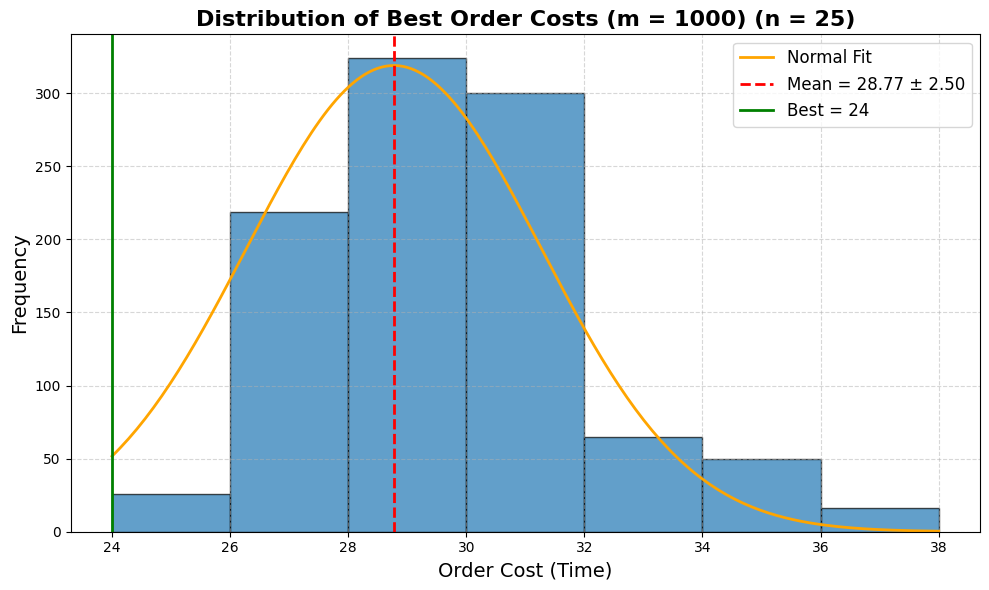

In [9]:
import random
import numpy as np
def GreedyRandomizedConstruction(J_product, alpha):
    J = J_product.copy()
    start_index = 0
    end_index = J.shape[0] - 1

    order = [start_index]
    for i in range(end_index - 1):
        current_index = order[-1]

        J_without_invalid_values = [J[current_index][j] for j in range(len(J[current_index])) if (j not in order) and (j != end_index)]
        minimum_cost = min(J_without_invalid_values)
        maximum_cost = max(J_without_invalid_values)
        cutoff_value = minimum_cost + alpha * (maximum_cost-minimum_cost)

        RCL_template = J[current_index] <= cutoff_value
        indizes = [j for j in range(len(RCL_template)) if RCL_template[j] and (j not in order) and (j != end_index)]
        winner_index = random.choice(indizes)

        order.append(winner_index)
    order.append(end_index)
    return order

def GRASP(J_product, compute_neighbours_func, alpha = 0.5):
    start_order = GreedyRandomizedConstruction(J_product, alpha)
    best_order, best_order_cost = local_search(J_product, compute_neighbours_func=compute_neighbours_func, start_order=start_order)
    return best_order, best_order_cost

def perform_GRASP_m_times(m, J_product, compute_neighbours_func, alpha = 0.5):
    best_orders, best_order_costs = [], []
    for i in range(m):
        best_order, best_order_cost = GRASP(J_product, compute_neighbours_func, alpha = alpha)
        best_orders.append(best_order)
        best_order_costs.append(best_order_cost)

    plot_costs(best_order_costs, shopping_list=shopping_list)

#best_order, best_order_cost = GRASP(J_product, compute_neighbours1, alpha = 0.3)
perform_GRASP_m_times(1000, J_product, compute_neighbours1, alpha = 0.1)

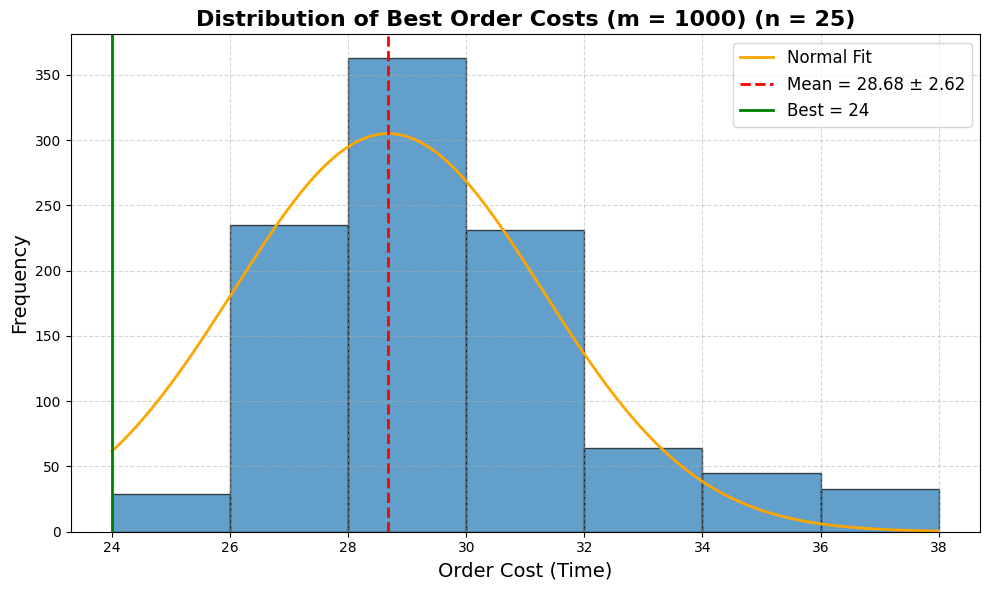

In [10]:
perform_GRASP_m_times(1000, J_product, compute_neighbours2, alpha = 0.1)